# Unsupervised machine learning techniques

Today we will continue working with the gene expression data of our mice, and try to find patterns in them with the help of unsupervised machine learning algorithms. Unsupervised methods are useful when we have so-called unlabeled data: samples with no group membership information, only their raw values.

Now our expression data isn't unlabeled: we know for every sample 1) what diet it had, 2) what strain it was. But we will not give that information to the upcoming ML methods. We will instead ask these methods to score / separate / cluster the samples based on their raw values only, and then we will verify whether they managed to do it in a way which is consistent with the labels that we had hidden from the algorithms.

The unsupervised techniques we will use today are principal component analysis (PCA), hierarchical clustering and K-means clustering, provided by the wonderful, feature-rich and easy-to-use `scikit-learn` package. Their website is worth taking a look for anyone interested in machine learning: it is not just a documentation, but also a great guide for a lot of techniques.

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Load the expression data

We will need the original raw expression data, and your differential expression analysis csv. Adapt the below steps to make sure we are on the same page.

In [2]:
xls = pd.read_excel('../files_day_five/aad0189_DataFileS5.xlsx', header=2)
expr = xls.groupby('Gene.1').mean()  # or 'Gene' if you had used that for your DE calculations
expr = expr.loc[:, expr.columns.str.contains('Liver')]
is_hfd = pd.Series(expr.columns.str.contains('HFD'), index=expr.columns)  # diet labels for verification
is_hfd

C57BL/6J_Liver_CD    False
DBA/2J_Liver_CD      False
BXD43_Liver_CD       False
BXD44_Liver_CD       False
BXD45_Liver_CD       False
BXD48_Liver_CD       False
BXD49_Liver_CD       False
BXD51_Liver_CD       False
BXD55_Liver_CD       False
BXD56_Liver_CD       False
BXD60_Liver_CD       False
BXD61_Liver_CD       False
BXD62_Liver_CD       False
BXD63_Liver_CD       False
BXD64_Liver_CD       False
BXD65_Liver_CD       False
BXD66_Liver_CD       False
BXD68_Liver_CD       False
BXD69_Liver_CD       False
BXD70_Liver_CD       False
BXD71_Liver_CD       False
BXD73_Liver_CD       False
BXD75_Liver_CD       False
BXD79_Liver_CD       False
BXD80_Liver_CD       False
BXD81_Liver_CD       False
BXD83_Liver_CD       False
BXD84_Liver_CD       False
BXD85_Liver_CD       False
BXD87_Liver_CD       False
                     ...  
BXD56_Liver_HFD       True
BXD61_Liver_HFD       True
BXD62_Liver_HFD       True
BXD63_Liver_HFD       True
BXD64_Liver_HFD       True
BXD65_Liver_HFD       True
B

Since `scikit-learn` likes to treat data as one sample per row, we should transpose our expression data matrix, such that rows stand for mice and columns stand for genes. Let's call the transposed form of `expr` as `data`.

In [3]:
data = expr.T
data

Gene.1,544988,100043387,0610007C21Rik,0610007L01Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,mCG_21548,rp9
C57BL/6J_Liver_CD,6.183000,10.384,12.389,10.2875,8.1160,12.281,8.3640,9.440,7.033,10.904,...,9.104,8.152,10.427,9.668,9.903,10.175,6.939,9.885,7.335,9.943
DBA/2J_Liver_CD,6.353333,9.848,12.559,10.3900,8.4220,12.305,8.2570,8.576,7.126,10.949,...,9.087,7.754,10.162,9.411,9.565,10.361,7.398,9.945,7.801,9.795
BXD43_Liver_CD,6.262333,10.108,12.647,10.4110,8.2350,11.949,8.5780,8.264,7.374,11.024,...,9.330,7.616,10.062,9.576,9.650,10.231,7.447,10.123,7.789,9.860
BXD44_Liver_CD,6.263667,9.860,12.639,10.4195,8.1350,11.895,8.5390,8.815,7.325,10.665,...,9.058,7.292,10.233,9.685,9.721,10.146,7.552,9.319,7.708,9.715
BXD45_Liver_CD,6.270000,9.392,12.515,10.3060,8.1980,12.160,8.2980,9.418,7.526,10.669,...,8.847,7.756,10.173,9.603,9.687,10.261,7.600,9.510,7.703,9.772
BXD48_Liver_CD,6.201333,9.926,12.659,10.4320,8.0925,12.102,8.3350,9.034,7.298,10.848,...,9.092,6.759,10.199,9.725,9.585,10.331,7.744,9.606,7.677,9.743
BXD49_Liver_CD,6.237000,10.105,12.571,10.2005,8.1460,11.903,8.2485,8.499,6.939,10.831,...,9.097,7.056,10.289,9.382,9.578,10.690,7.158,9.876,7.767,9.951
BXD51_Liver_CD,6.274667,10.040,12.512,10.4320,7.8765,12.257,8.1720,8.881,7.357,11.061,...,9.115,7.752,9.759,9.472,9.464,10.334,7.310,9.898,7.844,9.618
BXD55_Liver_CD,6.319000,10.128,12.651,10.3200,8.4000,12.378,8.1570,9.008,7.199,10.926,...,9.017,7.561,10.125,9.501,9.590,10.336,7.088,9.786,7.933,9.856
BXD56_Liver_CD,6.271000,9.410,12.529,10.2945,8.0930,11.697,8.1780,8.918,7.421,10.961,...,9.071,8.014,10.084,9.403,9.807,10.220,7.610,9.838,7.451,9.658


## Task 1: principal component analysis
PCA takes a set of high-dimensional samples (vectors), and transforms them to a smaller set of variables using an orthogonal transformation. It finds a set of orthogonal vectors (their dimension identical to the dimension of your data points) and projects every sample to each of these orthogonal vectors with a simple dot product. The projections are called principal components, and they have some interesting properties that we will not go into detail just yet.

### 1.1 Initialize a PCA object with 4 components and transform your data.

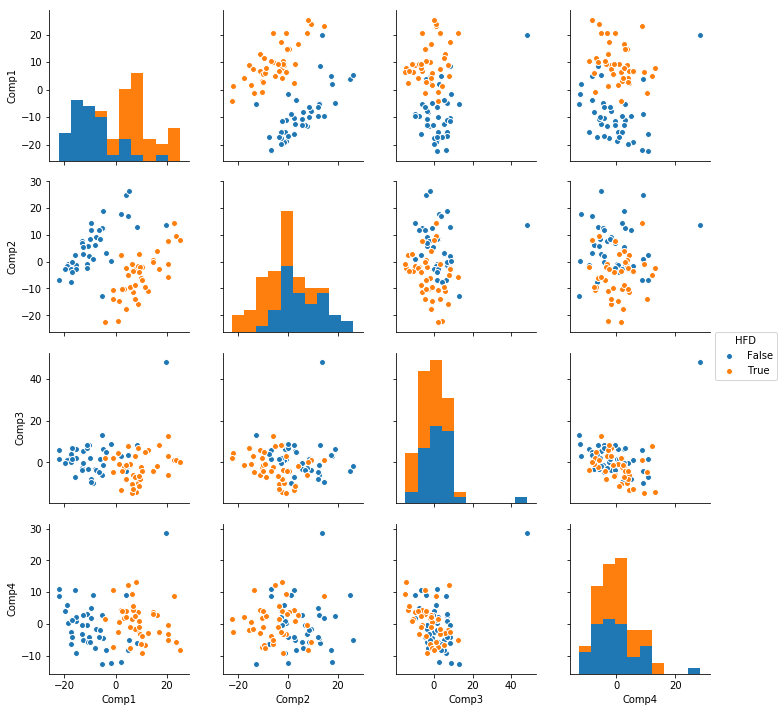

In [4]:
# Define components
pca = PCA(n_components=4)
# Perform PCA
pc_df = pca.fit_transform(data)
# Do pairplot
dataset = pd.DataFrame({'Comp1':pc_df[:,0],'Comp2':pc_df[:,1], 'Comp3': pc_df[:,2], 'Comp4': pc_df[:,3], 'HFD': is_hfd})
sns.pairplot(dataset, vars=['Comp1', 'Comp2', 'Comp3', 'Comp4'], hue='HFD')

### 1.2 Plot the components against each other

Plotting the first component against the second is simple enough with matplotlib `scatter`, but you can do better and create a scatter plot for each pair using seaborn's `pairplot`. This requires your data to be a `DataFrame`, but you know how to turn a numpy matrix into a DF.

### 1.2.1 Add color information based on the diet
Are you impressed?

### 1.2.2 Optional: is it enough to use every 200th gene and still get a nice PCA plot?

In [5]:
# I am very impressed because the PCA perfectly seperated HFD from CD without even knowing about the variables
# Unsupervised learning at its best

### 1.3 Find the component vectors that were used for the transformation. Are they orthogonal as promised? How would you verify it?

In [6]:
# Get dot product by transposing 
components = pca.components_
print(components.shape)
dot_product = np.dot(components, components.T)
dot_product
print(pca.explained_variance_ratio_)

(4, 21835)
[0.14460189 0.09516149 0.06550973 0.04348441]


### 1.3.1 Optional: How correlated are the transformed values with each other? Why is it important?

### 1.4: Compare the first component vector's weights with the log-foldchange vector from your differential expression analysis. Visualize them on a scatter plot, and interpret what you see.
Remember, you computed the fold-change values by comparing expression values between CD and the HFD diets. PCA had no access to this information, and yet... Well, this is why it's such a popular data exploration technique.

You can also try a scatter plot for weight vs p-values, log10-p, etc. Some of them might look familiar.

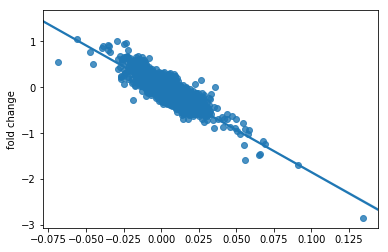

In [7]:
diff_exp = pd.read_csv('../files_day_six/pvalue_table.csv', sep=',', index_col='Gene.1')
diff_exp

fold = diff_exp['fold change']
fold

sns.regplot(components[0], fold)

### 1.5: Create a scatter plot for PC1 and PC2 only, but this time connect pairs of points that come from the same strain

This will involve `plt.scatter`, and a `for` loop with `plt.plot` calls.
The pattern of the resulting lines might be quite interesting. If it is, try to explain why.

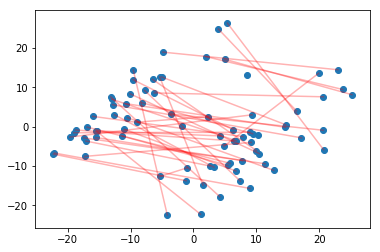

In [8]:
indexes = dataset.index.tolist()
from collections import Counter
for sample_id, count in Counter([x.split("_")[0] for x in indexes]).items():
    if count == 2:
        s1 = sample_id + "_Liver_CD"
        s2 = sample_id + "_Liver_HFD"
        plt.plot([dataset.loc[s1,"Comp1"], dataset.loc[s2,"Comp1"]], [dataset.loc[s1,"Comp2"], dataset.loc[s2,"Comp2"]], color='r', alpha=0.3)
plt.scatter(dataset["Comp1"], dataset["Comp2"])        

# A lot of lines seem to be parallel which shows that the second component seperated the strains pretty well

## Task 2: Hierarchical clustering

You had created a cluster-map before (Day 2) and remember those dendrograms on the top and left edges of the figure. They are a result of an unsupervised technique called hierarchical clustering. It iteratively merges single data points into bigger and bigger clusters based on their similarity, one at a time, until all points belong to one big cluster. Seaborn's `clustermap` does it on both axes by default, and produces a heatmap of the values as well.

### 2.1 Create a clustermap
From your first PCA component vector, take the genes with the 15 largest positive, and 15 largest negative weights, and create a smaller expression matrix with these 30 genes only. Use seaborn's `clustermap` to do a hierarchical clustering of genes and mice alike, as well as a heatmap.


### 2.2 Display the diet at the bottom of the mice's dendrogram
You will have to convert `is_hfd`'s values to color values first: `y` or `yellow` for 0 and `b` or `blue` for 1 should do fine.

In [9]:
compo_frame = pd.DataFrame.from_records(components.T, columns=['1', '2', '3','4'], index=data.columns)
#compo_frame.iloc[:,0]

# all_data = pd.concat([data,compo_frame],axis=0)

largest = compo_frame.nlargest(15, '1')
smallest = compo_frame.nsmallest(15, '1')
interesting_30 = largest.index.tolist() + smallest.index.tolist()

### 2.3 Standardize the matrix
It is hard to see the fine differences between the gene expression levels acros mice, because the range of general expression levels across genes is much higher. To circumvent this, we usually standardize our data: for every gene, subtract the mean and divide by the standard deviation.

You can do this with a pandas one-liner, or use sklearn's `StandardScaler` tool. You can simply extend the above cell with this.

### 2.4 Try different linkage methods
The linkage method defines how cluster similarities are defined. For example, `single` defines the distance of two clusters as the smallest distance of any two elements between them. Its opposite is `complete` which takes the largest distance of any two elements across two clusters. Middle grounds are `centroid`, `average`, and a few more. Look at how they affect the topology of the clusters. Which one seems most suitable in our case?

In [15]:
data_30genes = data.loc[:, interesting_30]
data_30_standardized = (data_30genes - data_30genes.mean())/data_30genes.std()

is_hfd = is_hfd.replace(True, 'y')
is_hfd = is_hfd.replace(False, 'b')

hfd_inc = pd.concat([data_30_standardized, is_hfd], axis=1)
hfd_inc
#sns.clustermap(data_30_standardized, method="ward", row_colors=hfd_inc[0])

,Cyp2b9,Lcn2,Cidea,Saa2,AB056442,Cyp2b13,Lgals1,Cd36,D630002G06Rik,Saa1,...,Agxt2l1,Gpr110,Csad,Ces6,V165-D-J-Cmu,Cyp4a12b,Gm15441,Grm8,Meg3,0
C57BL/6J_Liver_CD,-1.504203,1.761465,-0.859744,2.500871,-1.400874,-0.930377,0.042535,-1.206031,-1.190461,2.969063,...,-0.351074,2.474720,0.502096,1.533253,1.155068,0.030022,-0.760388,1.617331,-0.252691,b
DBA/2J_Liver_CD,-1.612530,-1.492794,-0.926582,-1.222316,-0.647312,-0.802289,-1.357041,-1.793392,-0.841211,-0.726924,...,-0.200263,1.663070,0.833494,1.098231,1.043979,1.063208,-0.364923,0.667015,1.857209,b
BXD43_Liver_CD,-1.598539,-0.758182,-0.850832,-0.727097,-1.336883,-1.062443,-1.510617,-1.186348,-1.362788,-0.623933,...,2.039286,1.731508,-0.036070,0.433518,0.850856,1.115405,3.160223,1.045496,0.427604,b
BXD44_Liver_CD,1.415414,1.382370,1.188469,1.686676,1.083302,0.569292,1.765684,1.451081,-0.123182,1.760197,...,-0.669286,-0.714248,-0.796584,-1.395313,0.722677,0.010064,-0.229764,-0.320327,0.106189,b
BXD45_Liver_CD,-1.476222,-1.642323,-0.933266,-1.422011,-0.920466,-0.990841,-1.267213,-2.296845,-0.889463,-1.347061,...,0.921774,2.317432,0.737190,0.880720,1.346482,0.909689,-0.836478,1.423977,3.624005,b
BXD48_Liver_CD,-1.114068,-1.010085,-0.286422,-1.166696,-1.150642,-0.701250,0.062819,-0.191874,-0.752750,-1.080454,...,1.339522,0.317124,1.782366,1.073870,0.254396,0.103711,0.800448,0.265907,0.047033,b
BXD49_Liver_CD,-1.226392,-1.098188,-1.123383,-0.688900,-1.208902,-1.157117,-0.178654,-1.647329,-0.923928,-0.894193,...,0.577924,1.498579,2.006130,0.642328,1.351609,0.197358,1.661460,0.952932,-0.789040,b
BXD51_Liver_CD,-1.566961,-1.425165,-0.734980,-1.463559,-1.490652,-0.893780,-1.758851,-1.956030,-1.165186,-1.265983,...,1.119337,1.543003,1.129485,0.440478,0.826929,0.723930,2.824829,1.526825,1.969606,b
BXD55_Liver_CD,-1.648905,-1.807363,-0.599076,-1.740318,-1.145866,-0.874686,-0.538931,-1.119014,-0.866486,-1.524556,...,0.148112,0.073389,2.103850,0.873760,0.960235,1.296558,2.183074,1.512426,1.301142,b
BXD56_Liver_CD,-1.204407,-0.939353,-0.890192,-0.505287,-1.364581,-0.772852,-0.142916,-1.599677,-0.838913,-0.777324,...,1.389289,0.151432,1.186134,1.105191,0.727804,0.762310,0.497091,0.743122,0.674087,b


## Task 3: K-means clustering

K-means clustering attempts to create `k` virtual samples, whose average distance to the nearest actual samples is as small as possible. These `k` virtual samples are called cluster centers/prototypes or centroids. Each sample is assigned to the nearest centroid, therefore partitioning the samples to k clusters.

### 3.1 Perform k-means clustering on the expression dataset. What k should you choose?

In [11]:
# Chose k=2 due the fact that two components already represent the data very well
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

### 3.2 Compare the resulting clusters with the diet labels

In [12]:
# Get original labels instead of coloring labels
is_hfd = is_hfd.replace('y', True)
is_hfd = is_hfd.replace('b', False)

kmeans_df = pd.DataFrame(kmeans.labels_, index=is_hfd.index)

kmean_merge = pd.concat([is_hfd, kmeans_df], axis=1)
kmean_merge.columns = ['is_hfd', 'cluster']

# Looking at the data it is clear that CD and HFD got perfectly clustered besided one element of CD which was clustered
# to the HFD cluster
count_table = pd.crosstab(kmean_merge.iloc[:,0]==True, kmean_merge.iloc[:,1]==1)
count_table

cluster,False,True
is_hfd,,
False,40,1
True,0,40


### 3.3 Optional: with k=2, take the centroids, and transform them with the same PCA that you had trained earlier. Mark them on the PC1 vs PC2 plot.

In [13]:
# Perform PCA
pc_df = pca.fit_transform(kmeans.cluster_centers_)
pc_df

array([[-1.11518164e+01,  7.34395330e-14],
       [ 1.11518164e+01,  7.34395330e-14]])

### 3.4 Train a 2-means clustering on every second sample and predict on the other half of the samples
Since our CD and HFD samples come in two big batches, you can just use `::2` and `1::2` to split them. What do you find?

In [14]:
# Chose k=2 due the fact that two components already represent the data very well
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[::2])
kmeans.predict(data[1::2])

# We find the exact same result

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)